# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# План работы:

1.	Изучим информацию о данных
2.	Подготовим данные к анализу
    1.	Найдем пропущенные значения и заполним их, где это возможно
    2.	Проверим типы данных
    3.	Проверим уникальность значений и удалим дубликаты
    4.	Найдем выбросы и уберем аномалии из таблицы
    5.	Приведем столбцы к норме 
3.	Добавим в таблицу новые столбцы с данными
4.	Проведём исследовательский анализ данных 
    1.	Изучим параметры объектов
    2.	Изучим скорость продажи объектов недвижимости
    3.	Изучим зависимость цены от разных факторов
    4.	Найдем среднюю цену квадратного метра в населенных пунктах 
    5.	Выясним среднюю цену каждого километра в г. Санкт-Петербурге
5.	Подведем итоговый вывод



## Откройте файл с данными и изучите общую информацию. 

### Импорт необходимых библиотек. Считаем данные из csv-файла в датафрейм и сохрани в переменную data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # опция для вывода всех колонок 

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

### Вывод первых 5 строчек датафрейма data на экран

In [3]:
display (data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод основной информации о датафрейме с помощью метода info()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

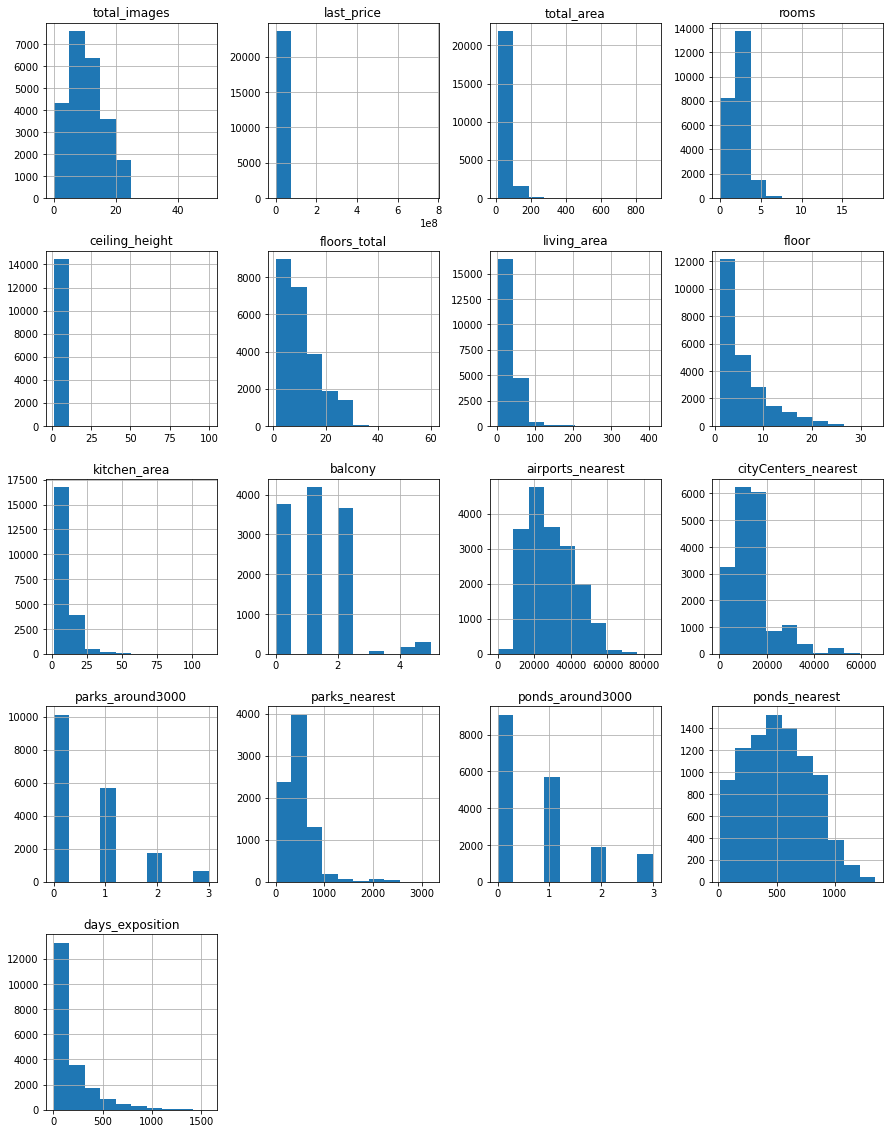

In [5]:
data.hist(figsize=(15, 20))
plt.show()

## Предобработка данных

### Работа с пропусками

#### Вывод пропущенных значений для каждого столбца 

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Вывод:** Большая часть столбцов имеет пропуски данных. Основную долю внимания придётся уделить пропущенным/отсутствующим значениям в таблице

In [7]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

#### Проверим значения колонки "ceiling_height"

##### Для начало выведем на экран cтандартное отклонение

In [9]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Итак, мы видим, что в датаферйме есть данные не похожи на реалестичные. Не бывает крвартир c потолком ниже 2 метров и выше прдположим 8 метров. 

##### Теперь уберем из данных предельно-допустимые значения и вычеслим среднюю

In [10]:
data.query('ceiling_height >= 2 and ceiling_height <= 8')['ceiling_height'].mean()

2.7278873920552678

#####  Заменим все пустые строки на среднее значение

In [11]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.72)

##### Так же заменим строки с предельно-допустимыми значениями

In [12]:
data.loc[data['ceiling_height'] < 2, 'ceiling_height'] = (2.72)
data.loc[data['ceiling_height'] > 8, 'ceiling_height'] = (2.72)

##### Проверим результат

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Отлично, пропусков в столбце ceiling_height больше нет. Но есть данные отличающиеся от предельно-допустимых значений, к ним мы вернемся позже.

#### Проверим значения колонки "floors_total"

##### Вывидим на экран строки с пустыми зачениями в столбце "floors_total"

In [14]:
display (data.loc[data['floors_total'].isna()].head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.20,2018-10-02T00:00:00,2,2.72,NaN,30.80,4,NaN,False,False,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.10,2016-11-23T00:00:00,1,2.72,NaN,20.75,1,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.80,2015-08-01T00:00:00,2,2.72,NaN,38.40,12,NaN,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.60,2017-04-06T00:00:00,3,2.72,NaN,47.10,8,NaN,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.00,2017-04-22T00:00:00,1,2.72,NaN,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
1930,1,9750000.0,66.77,2016-05-13T00:00:00,2,2.72,NaN,NaN,4,NaN,False,False,NaN,0.0,Санкт-Петербург,39886.0,10660.0,1.0,2276.0,3.0,244.0,90.0
2392,7,5395770.0,53.00,2017-06-29T00:00:00,2,2.72,NaN,29.00,22,NaN,False,False,9.00,0.0,Санкт-Петербург,43074.0,10820.0,0.0,NaN,0.0,NaN,48.0
2846,4,2325000.0,27.80,2016-09-21T00:00:00,1,2.72,NaN,19.40,15,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,307.0
2952,10,6500000.0,54.30,2019-04-23T00:00:00,1,2.72,NaN,22.20,6,NaN,False,False,12.30,NaN,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
3031,9,6400000.0,56.70,2018-03-27T00:00:00,2,2.72,NaN,32.00,12,NaN,False,False,12.00,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,231.0


В столбце "floors_total" пропуски пока не будем трогать. Причина отсутствия данных не понятна.

#### Проверим значения колонки "living_area"

##### Вывидим на экран строки с пустыми зачениями в столбце "living_area"

In [15]:
display (data.loc[data['living_area'].isna()].head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.72,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.72,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.72,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.72,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.72,13.0,NaN,13,NaN,False,False,NaN,NaN,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0
60,3,2740000.0,35.0,2018-01-01T00:00:00,1,2.72,12.0,NaN,8,NaN,False,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,11.0
81,9,10949000.0,68.0,2018-12-27T00:00:00,1,2.72,10.0,NaN,6,NaN,False,False,NaN,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,3,4500000.0,80.5,2018-01-15T00:00:00,3,2.72,25.0,NaN,16,NaN,False,False,NaN,NaN,посёлок Шушары,12430.0,18217.0,0.0,NaN,0.0,NaN,60.0
116,18,10999000.0,97.2,2017-11-13T00:00:00,3,2.50,16.0,NaN,16,NaN,False,False,18.3,5.0,Санкт-Петербург,19426.0,21138.0,0.0,NaN,2.0,390.0,394.0


Причина пропуска данных в столбце "living_area" не понятна. Оставим пока как есть.

#### Проверим значения колонки "is_apartment"

Из описания данных таблицы мы заняем, что столбец "is_apartment", должен иметь булевое значение.

##### Проверим уникальные значения столбца

In [16]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Предположим, что все пропущенные значения являются False, т.к. апартаменты появились сравнительно не давно и раньше этого столбца не было.

##### Заменим все пустые значения на булевое значение False

In [17]:
data['is_apartment'] = data['is_apartment'].fillna(False)

##### Проверим результат

In [18]:
data['is_apartment'].unique()

array([False,  True])

#### Проверим значения колонки "balcony"

##### Проверим уникальные значения столбца

In [19]:
print (data['balcony'].unique())

[nan  2.  0.  1.  5.  4.  3.]


Продавец не указал число болконов, скорее всего и попросту нет. Заменин все неизвестные значения на 0

##### Заменим все пустые значения на 0

In [20]:
data['balcony'] = data['balcony'].fillna(0)

#####  Проверим результат

In [21]:
print (data['balcony'].unique())

[0. 2. 1. 5. 4. 3.]


Остальные пропуски не будет трогать, т.к. нет закономерности

### Изменение типов данных

#### Изменим тип данных столбца "first_day_exposition" с использованием метода to_datetime()

In [22]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%d')

#### Вывод результата

In [23]:
display (data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.72,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.72,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.72,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Столбец перевели в формат с датой без времени, т.к. время не указано

#### Замена типа данных столбца "floors_total" на "int"

In [24]:
data['balcony'] = data['balcony'].astype('int')

#### Замена типа данных столбца "parks_around3000" на "int"

In [25]:
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')

Предположим, что пропущенные значения означает, что в ближайших 3-х километров нет пароков.

#### Замена типа данных столбца "ponds_around3000" на "int"

In [26]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')

#### Замена типа данных столбца "floors_total" на "int"

In [27]:
data['floors_total'] = data['floors_total'].fillna(0).astype('int')

Предположим, что пропущенные значения означает, что в ближайших 3-х километров нет водоемов

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### Поиск дубликатов

Обработайте неявные дубликаты в столбце "locality_name". В этом столбце есть одни и те же населенные пункты, но записанные по-разному.

#### Вывод уникальных значение столбца

In [29]:
print (data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

#### Приводим все к нижнему регистру

In [30]:
data['locality_name'] = data['locality_name'].str.lower()

#### Выполним замену в написании "поселок" на "посёлок"

In [31]:
data['locality_name'] = data['locality_name'].str.replace('поселок','посёлок')

#### Проверка результата

In [32]:
print (data['locality_name'].unique())

['санкт-петербург' 'посёлок шушары' 'городской посёлок янино-1'
 'посёлок парголово' 'посёлок мурино' 'ломоносов' 'сертолово' 'петергоф'
 'пушкин' 'деревня кудрово' 'коммунар' 'колпино'
 'посёлок городского типа красный бор' 'гатчина' 'деревня фёдоровское'
 'выборг' 'кронштадт' 'кировск' 'деревня новое девяткино'
 'посёлок металлострой' 'посёлок городского типа лебяжье'
 'посёлок городского типа сиверский' 'посёлок молодцово'
 'посёлок городского типа кузьмоловский'
 'садовое товарищество новая ропша' 'павловск' 'деревня пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк'
 'деревня куттузи' 'посёлок аннино' 'посёлок городского типа ефимовский'
 'посёлок плодовое' 'деревня заклинье' 'посёлок торковичи'
 'посёлок первомайское' 'красное село' 'посёлок понтонный' 'сясьстрой'
 'деревня старая' 'деревня лесколово' 'посёлок новый свет' 'сланцы'
 'село путилово' 'ивангород' 'мурино' 'шлиссельбург' 'никольское'
 'зеленогорск' 'сосновый бор' 'деревня оржицы' 'деревня кальтино'

**Вывод:** Довольно распространённая ошибка с применением буквы "ё" в тексте, а так же использование разного регистра букв - это человеческий фактор возникновения ошибки.

In [33]:
# check
data['locality_name'].nunique()

330

### Обработка столбцов

#### Приведение название столбцов к единому типу

In [34]:
data.rename(columns = {'cityCenters_nearest':'city_centers_nearest','parks_around3000':'parks_around_3km', 'ponds_around3000':'ponds_around_3km'}, inplace=True)

#### Проверка результата

In [35]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3km', 'parks_nearest', 'ponds_around_3km',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

### Найдем и устраним редкие и выбивающиеся значения.

#### Проверка столбца "airports_nearest"

In [36]:
data.query('airports_nearest == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition
21085,0,7000000.0,34.7,2018-09-23,1,2.7,9,19.8,3,False,False,False,6.0,2,санкт-петербург,0.0,22801.0,0,NaN,0,NaN,60.0


Не бывает квартир в аэропорту, скорее всего это ошибка данных. Замени значение 0 на None

In [37]:
data.loc[data['airports_nearest'] == 0, 'airports_nearest'] = None

Проверим минимальное расстояние до аэропорта

In [38]:
data['airports_nearest'].min()

6450.0

**Вывод:** В результате проведенной обработки данных, можно сделать вывод, что внушительная часть данных была утеряна при выгрузке или отсутствует. Это может повлиять на итоговую статистику, а также на решение при покупке квартир. Об этом необходимо сообщить сотрудникам ответственным за выгрузку и сбор данных.

#### Проверка столбца "rooms"

In [39]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

Мы видим, что есть квартиры с 0 комнат. Возможно это квартиры студии. Проверим

In [40]:
data.query('rooms == 0').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30,0,2.72,24,15.50,2,False,True,False,NaN,2,посёлок мурино,NaN,NaN,0,NaN,0,NaN,181.0
349,4,2320000.0,25.00,2017-09-27,0,2.72,14,17.00,1,False,False,True,NaN,0,деревня кудрово,NaN,NaN,0,NaN,0,NaN,45.0
440,8,2480000.0,27.11,2018-03-12,0,2.72,17,24.75,4,False,True,False,NaN,2,санкт-петербург,38171.0,15015.0,0,NaN,2,982.0,64.0
508,0,3375000.0,34.40,2017-03-28,0,2.72,26,24.30,19,False,False,True,NaN,1,посёлок парголово,53115.0,19292.0,0,NaN,1,593.0,430.0
608,2,1850000.0,25.00,2019-02-20,0,2.72,10,NaN,7,False,True,False,NaN,0,посёлок шушары,NaN,NaN,0,NaN,0,NaN,29.0
697,12,2500000.0,24.10,2017-12-01,0,2.75,25,17.50,21,False,True,False,NaN,0,деревня кудрово,NaN,NaN,0,NaN,0,NaN,201.0
716,5,1500000.0,17.00,2017-06-07,0,2.70,9,12.00,1,False,True,False,NaN,0,посёлок шушары,18654.0,29846.0,0,NaN,0,NaN,40.0
780,9,2600000.0,26.10,2018-02-20,0,2.72,18,NaN,8,False,False,True,NaN,1,посёлок мурино,NaN,NaN,0,NaN,0,NaN,45.0
839,14,1900000.0,35.00,2017-04-14,0,2.70,5,15.00,3,False,False,True,NaN,1,посёлок новый свет,NaN,NaN,0,NaN,0,NaN,7.0
946,5,2200000.0,23.00,2016-09-27,0,2.72,27,18.00,7,False,False,True,NaN,2,посёлок мурино,NaN,NaN,0,NaN,0,NaN,483.0


Предположение подтвердились, это квартиры-студии. Оставим все как есть

In [41]:
data.rooms.value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Исключим редкие квартиры из таблицы

In [42]:
data = data.query('rooms < 10')

Проверим результат

In [43]:
data.rooms.value_counts()

1    8047
2    7940
3    5814
4    1180
5     326
0     197
6     105
7      59
8      12
9       8
Name: rooms, dtype: int64

#### Проверка столбца "total_area"

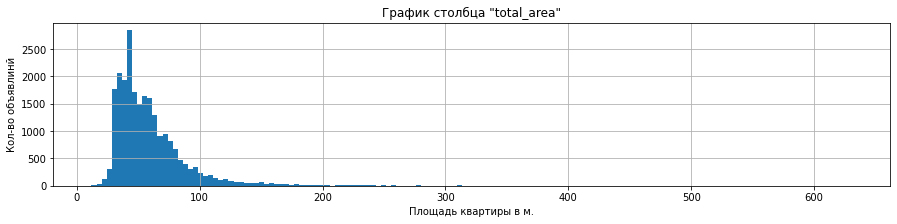

In [44]:
data.total_area.hist(bins = 150, figsize = (15,3))
plt.title('График столбца "total_area"')
plt.xlabel('Площадь квартиры в м.')
plt.ylabel('Кол-во объявлинй')
plt.show()

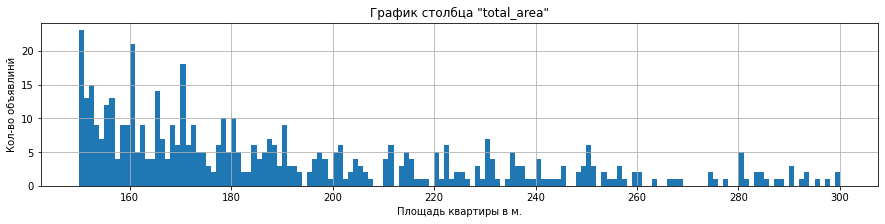

In [45]:
data.total_area.hist(bins = 150, figsize = (15,3), range= (150,300));
plt.title('График столбца "total_area"')
plt.xlabel('Площадь квартиры в м.')
plt.ylabel('Кол-во объявлинй')
plt.show()

И так мы видим, что с общей площадъю квартиры больше 190 кв.м совсем редкость. Исключм их из таблицы

In [46]:
data = data.query('total_area <= 190')

Проверим результат

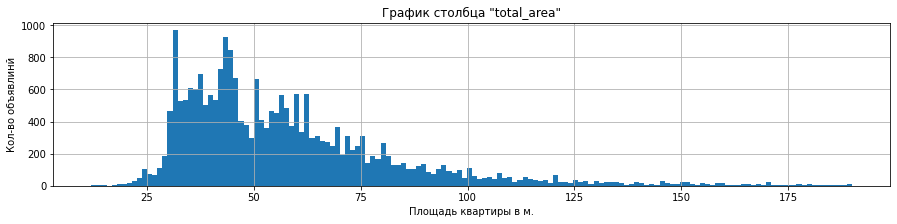

In [47]:
data.total_area.hist(bins = 150, figsize = (15,3))
plt.title('График столбца "total_area"')
plt.xlabel('Площадь квартиры в м.')
plt.ylabel('Кол-во объявлинй')
plt.show()

#### Проверка столбца "days_exposition"

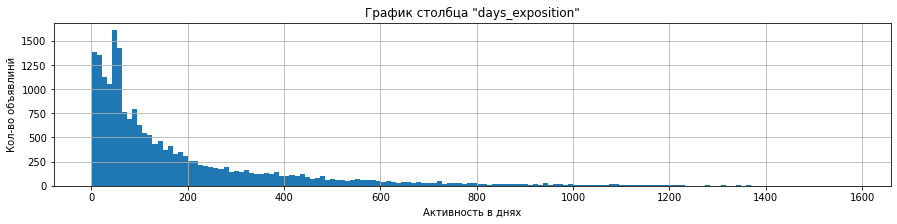

In [48]:
data.days_exposition.hist(bins = 150, figsize = (15,3));
plt.title('График столбца "days_exposition"')
plt.xlabel('Активность в днях')
plt.ylabel('Кол-во объявлинй')
plt.show()

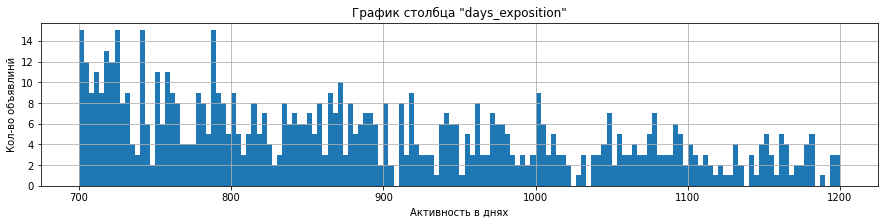

In [49]:
data.days_exposition.hist(bins = 150, figsize = (15,3), range= (700, 1200))
plt.title('График столбца "days_exposition"')
plt.xlabel('Активность в днях')
plt.ylabel('Кол-во объявлинй')
plt.show()

Обявления которые активны больше 800 дней, либо уже не актуальны и их забыли зкрыть, либо не интересны дла основной мыссы покупателей, по причини очень высокой цены или не стандартной планировки. Уберем их из иследования.

In [50]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23442 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23442 non-null  int64         
 1   last_price            23442 non-null  float64       
 2   total_area            23442 non-null  float64       
 3   first_day_exposition  23442 non-null  datetime64[ns]
 4   rooms                 23442 non-null  int64         
 5   ceiling_height        23442 non-null  float64       
 6   floors_total          23442 non-null  int64         
 7   living_area           21573 non-null  float64       
 8   floor                 23442 non-null  int64         
 9   is_apartment          23442 non-null  bool          
 10  studio                23442 non-null  bool          
 11  open_plan             23442 non-null  bool          
 12  kitchen_area          21198 non-null  float64       
 13  balcony         

In [51]:
data = data.query('days_exposition < 801 | days_exposition.isna()')

In [52]:
# check
data.shape[0]

22871

Проверим результат

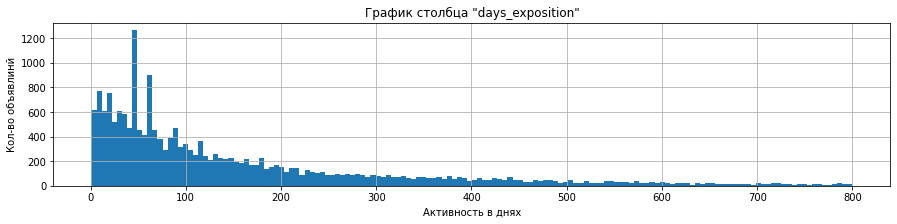

In [53]:
data.days_exposition.hist(bins = 150, figsize = (15,3));
plt.title('График столбца "days_exposition"')
plt.xlabel('Активность в днях')
plt.ylabel('Кол-во объявлинй')
plt.show()

#### Проверка столбца "last_price"

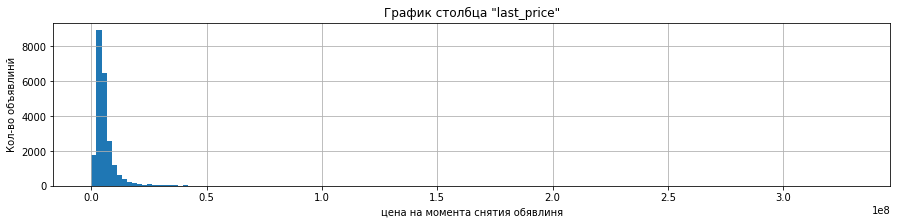

In [54]:
data. last_price.hist(bins = 150, figsize = (15,3));
plt.title('График столбца "last_price"')
plt.xlabel('цена на момента снятия обявлиня')
plt.ylabel('Кол-во объявлинй')
plt.show()

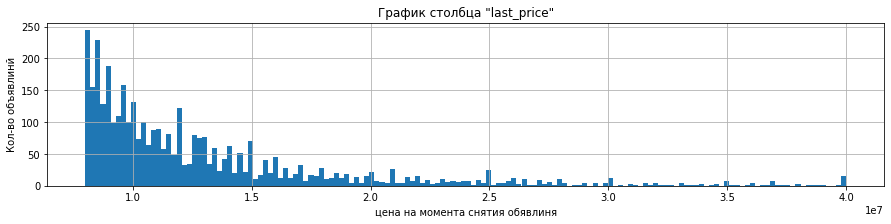

In [55]:
data.last_price.hist(bins = 150, figsize = (15,3), range=(8000000,40000000));
plt.title('График столбца "last_price"')
plt.xlabel('цена на момента снятия обявлиня')
plt.ylabel('Кол-во объявлинй')
plt.show()

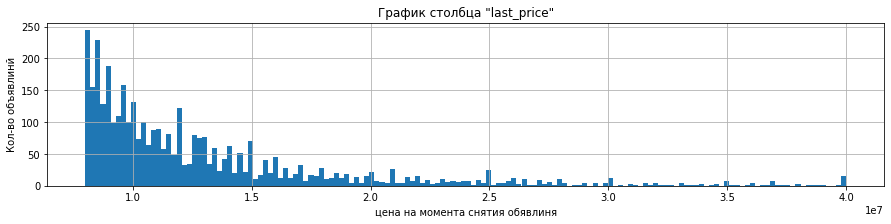

In [56]:
data.last_price.hist(bins = 150, figsize = (15,3), range=(8_000_000,40_000_000));
plt.title('График столбца "last_price"')
plt.xlabel('цена на момента снятия обявлиня')
plt.ylabel('Кол-во объявлинй')
plt.show()

Цены выше 20 млн. руб. встречаются не часто. Исключим их из траблицы

In [57]:
data = data.query('last_price <= 20000000')

In [58]:
data.shape[0]

22391

Проверим результат

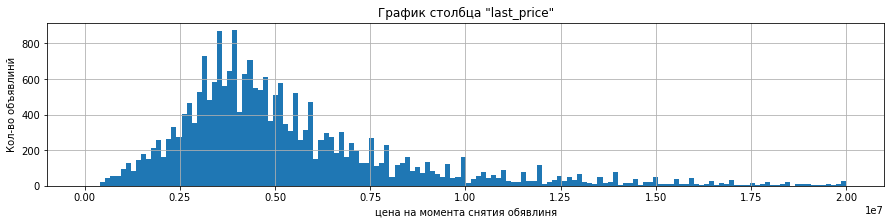

In [59]:
data.last_price.hist(bins = 150, figsize = (15,3) );
plt.title('График столбца "last_price"')
plt.xlabel('цена на момента снятия обявлиня')
plt.ylabel('Кол-во объявлинй')
plt.show()

#### Проверка столбца "living_area"

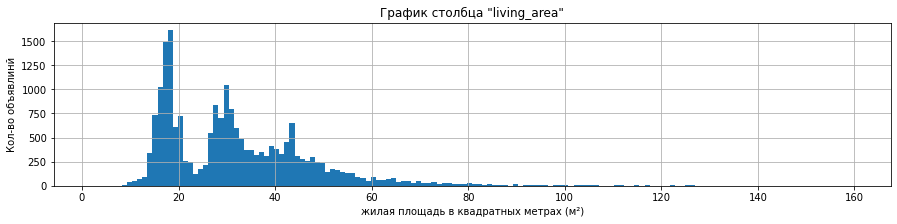

In [60]:
data.living_area.hist(bins = 150, figsize = (15,3) )
plt.title('График столбца "living_area"')
plt.xlabel('жилая площадь в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

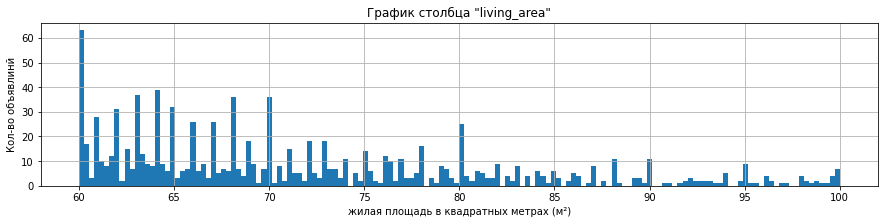

In [61]:
data.living_area.hist(bins = 150, figsize = (15,3), range=(60,100))
plt.title('График столбца "living_area"')
plt.xlabel('жилая площадь в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

По гистрограмме видно, объявлений с жилой площядью выше 80 фактически нет. уберем их из таблицы

In [62]:
data.shape[0]

22391

In [63]:
data = data.query('living_area <= 80 | living_area.isna()')

In [64]:
data.shape[0]

22109

Проверим данные

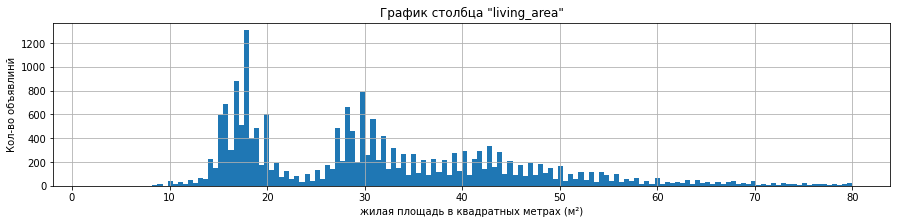

In [65]:
data.living_area.hist(bins = 150, figsize = (15,3) )
plt.title('График столбца "living_area"')
plt.xlabel('жилая площадь в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

#### Проверка столбца "kitchen_area"

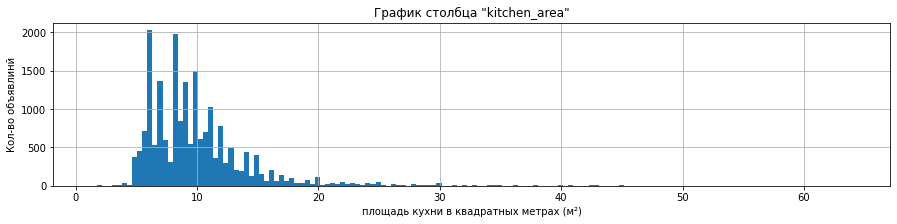

In [66]:
data.kitchen_area.hist(bins = 150, figsize = (15,3) )
plt.title('График столбца "kitchen_area"')
plt.xlabel('площадь кухни в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

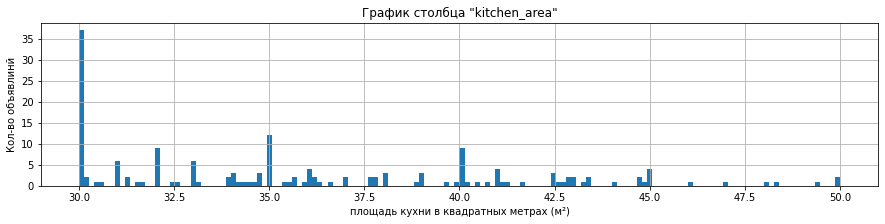

In [67]:
data.kitchen_area.hist(bins = 150, figsize = (15,3), range=(30,50) )
plt.title('График столбца "kitchen_area"')
plt.xlabel('площадь кухни в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

По гистрограмме видно, объявлений с кухонной площядью выше 30 фактически нет. уберем их из таблицы

In [68]:
data.shape[0]

22109

In [69]:
data = data.query('kitchen_area <= 30 | kitchen_area.isna()')

In [70]:
data.shape[0]

21972

Проверим результат

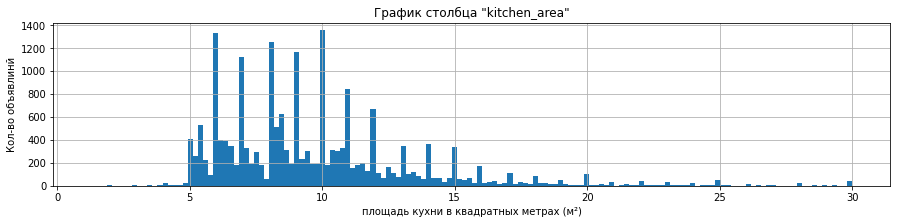

In [71]:
data.kitchen_area.hist(bins = 150, figsize = (15,3) )
plt.title('График столбца "kitchen_area"')
plt.xlabel('площадь кухни в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

#### Проверка столбца "floors_total"

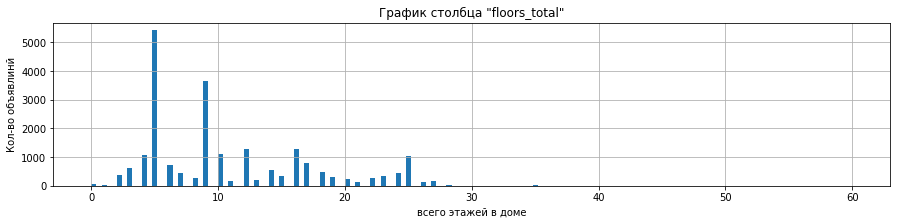

In [72]:
data.floors_total.hist(bins = 150, figsize = (15,3) )
plt.title('График столбца "floors_total"')
plt.xlabel('всего этажей в доме')
plt.ylabel('Кол-во объявлинй')
plt.show()

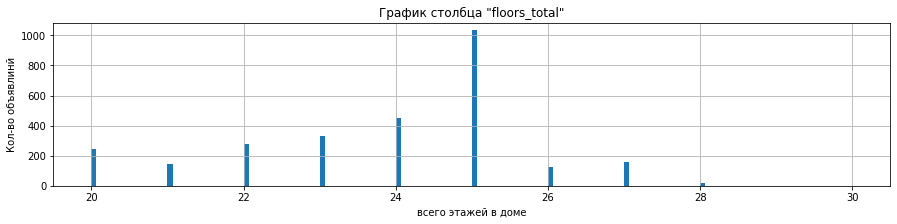

In [73]:
data.floors_total.hist(bins = 150, figsize = (15,3), range=(20,30) )
plt.title('График столбца "floors_total"')
plt.xlabel('всего этажей в доме')
plt.ylabel('Кол-во объявлинй')
plt.show()

Домов выше чем с 30-ю этажами фактически нет. уэдалим из табилцы как выброс

In [74]:
data = data.query('floors_total <= 30')

Проверим результат

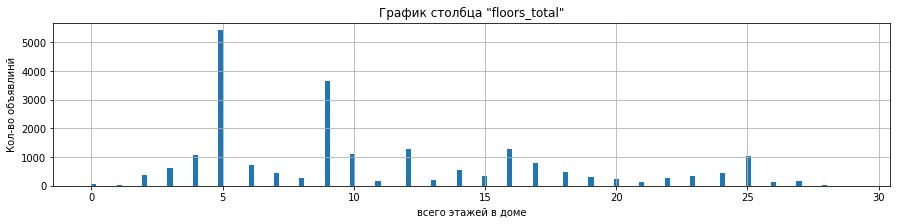

In [75]:
data.floors_total.hist(bins = 150, figsize = (15,3) )
plt.title('График столбца "floors_total"')
plt.xlabel('всего этажей в доме')
plt.ylabel('Кол-во объявлинй')
plt.show()

In [76]:
(data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   )

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,21940,21940.0,21940.0,19082.0,21940.0,20181.0,19798.0,21940,21940
min,0,12.0,2.0,1.0,430000.0,2.0,1.3,1,0
max,7,190.0,8.0,800.0,20000000.0,80.0,30.0,27,29


**Вывод:** В этом задании мы выявили и удалили все редкие и аномальные значения из таблицы. Что бы они нам не повлияли на результат.

In [77]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,940.00","21,940.00","21,940.00","19,082.00","21,940.00","20,181.00","19,798.00","21,940.00","21,940.00"
min,0.00,12.00,2.00,1.00,"430,000.00",2.00,1.30,1.00,0.00
max,7.00,190.00,8.00,800.00,"20,000,000.00",80.00,30.00,27.00,29.00


In [78]:
data.rooms.value_counts().to_frame()

,rooms
1,7876
2,7618
3,5296
4,847
0,191
5,99
6,11
7,2


Исключим редкие квартиры из таблицы

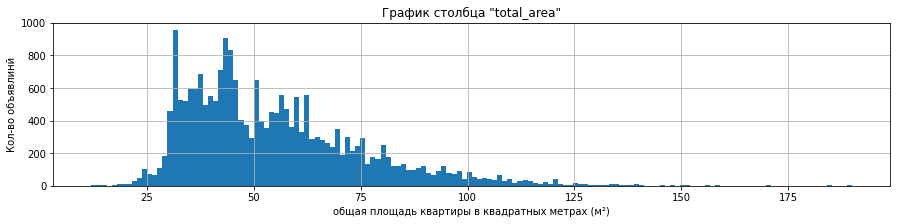

In [79]:
data.total_area.hist(bins = 150, figsize = (15,3),)
plt.title('График столбца "total_area"')
plt.xlabel('общая площадь квартиры в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

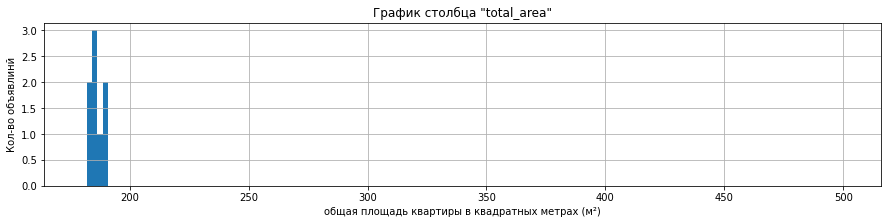

In [80]:
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));
plt.title('График столбца "total_area"')
plt.xlabel('общая площадь квартиры в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

In [81]:
# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,25.00,2.50,4.00,"996,560.00",13.00,5.00,1.00,2.00
0.5,2.00,50.00,2.72,90.00,"4,500,000.00",29.70,9.00,4.00,9.00
0.9,3.00,82.60,2.85,396.00,"8,900,000.00",50.00,14.50,13.00,22.00
0.9976,5.00,135.52,3.95,781.00,"18,867,320.00",78.00,29.05,25.00,27.00


## Посчитайте и добавьте в таблицу новые столбцы

### Добавление в таблицу столбца с ценой за один квадратный метр

In [82]:
data['total_area_price'] = (data.query('last_price < 12000000')['last_price']/data['total_area']).round(2)
#так же убрали выбросы по цене, что бы в дальнейшем не искажало статистику

### Добавление в таблицу столбца с днем недели публикации объявления

In [83]:
data['exposition_week'] = data['first_day_exposition'].dt.dayofweek

### Добавление в таблицу столбца с месяцем публикации объявления

In [84]:
data['exposition_month'] = data['first_day_exposition'].dt.month

### Добавление в таблицу столбца с годом публикации объявления

In [85]:
data['exposition_year'] = data['first_day_exposition'].dt.year

### Добавление в таблицу столбца с типом этажа квартиры

#### Создадим функцию для определения категории этажа

In [86]:
def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'

#### Создадим столбец с типом этажей и заполним его

In [87]:
data['floor_group'] = data.apply(floor_type, axis = 1)
data['floor_group']
#data['floor_group'] = data.apply(floor_type, axis=1)

0        другой
1        первый
2        другой
5        другой
6        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: floor_group, Length: 21940, dtype: object

### Добавление в таблицу столбца с расстоянием до центра города в километрах

In [88]:
data['centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round()

Вывод на экран таблицы с добавленными столбцами

In [89]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition,total_area_price,exposition_week,exposition_month,exposition_year,floor_group,centers_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,NaN,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.72,11,18.6,1,False,False,False,11.0,2,посёлок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.72,5,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0
5,10,2890000.0,30.4,2018-09-10,1,2.72,12,14.4,5,False,False,False,9.1,0,городской посёлок янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065.79,0,9,2018,другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.72,26,10.6,6,False,False,False,14.4,1,посёлок парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,99195.71,3,11,2017,другой,19.0


## Проведите исследовательский анализ данных

### Изучение пораметров объектов

#### Общая площадь

Изучим общую площадь квартиры, построим диограмму размаха и гистрограмму

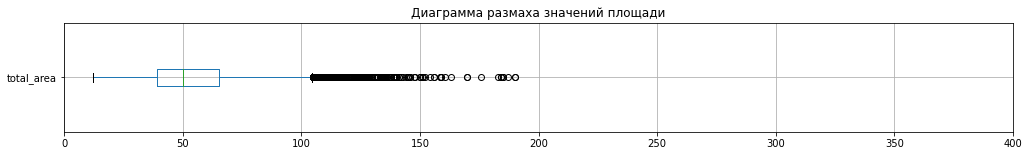

In [90]:

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

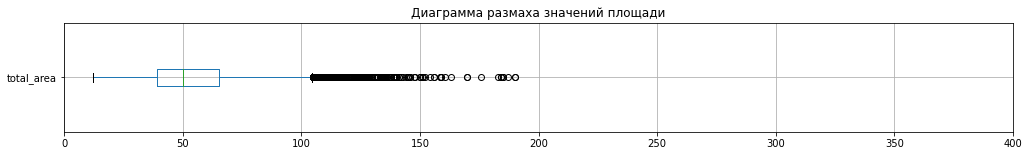

In [91]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

In [92]:
data['total_area'].describe()

count    21940.000000
mean        54.667197
std         20.534834
min         12.000000
25%         39.200000
50%         50.000000
75%         65.400000
max        190.000000
Name: total_area, dtype: float64

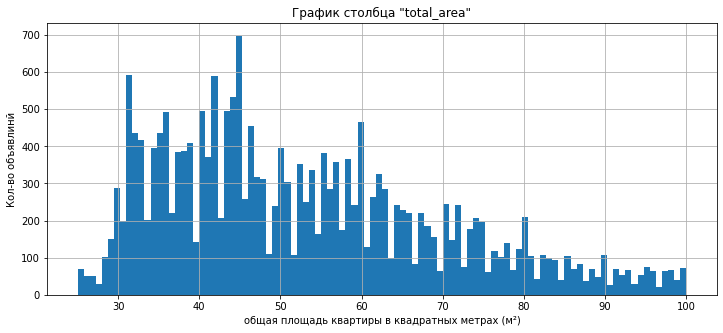

In [93]:
data['total_area'].hist(bins=100, range=(25,100), figsize=(12,5))
plt.title('График столбца "total_area"')
plt.xlabel('общая площадь квартиры в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** По гистраграмме видно, что диапазон общей площади квариры составляет от 25 до 100 м.кв. Самое высокое количество предложений приходится на квартиры с 45 кв.м общей площади.

#### Жилая площадь

Изучим жилую площадь квартиры, построим диограмму размаха и гистрограмму

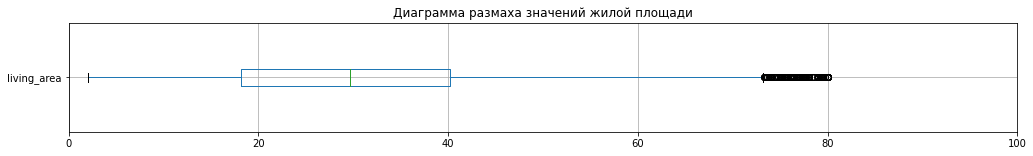

In [94]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений жилой площади')
ax.set_xlim(0, 100);


In [95]:
data['living_area'].describe()

count    20181.000000
mean        31.220565
std         13.786716
min          2.000000
25%         18.200000
50%         29.700000
75%         40.200000
max         80.000000
Name: living_area, dtype: float64

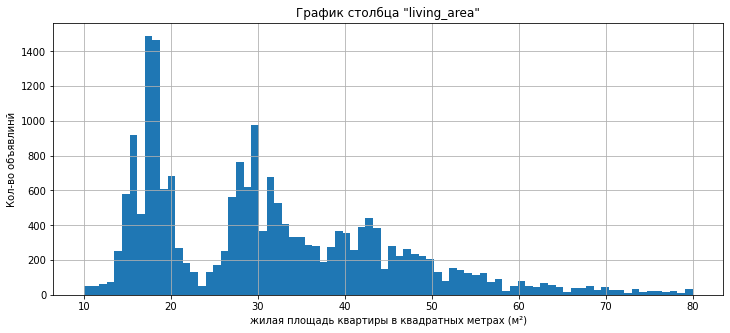

In [96]:
data['living_area'].hist(bins=80, range=(10,80), figsize=(12,5))
plt.title('График столбца "living_area"')
plt.xlabel('жилая площадь квартиры в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Ввидно то, что в предложении о продажи очень много квартир с жилой площадью 18 кв.м и ниже.

#### Площадь кухни

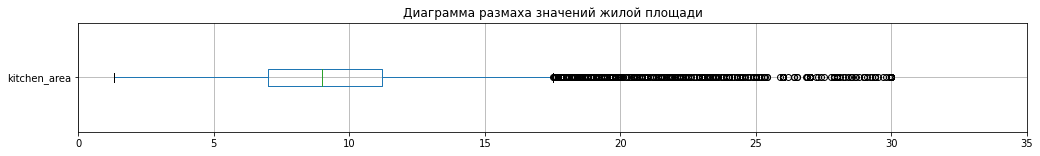

In [97]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений жилой площади')
ax.set_xlim(0, 35);

In [98]:
data['kitchen_area'].describe()

count    19798.000000
mean         9.770730
std          3.841122
min          1.300000
25%          7.000000
50%          9.000000
75%         11.200000
max         30.000000
Name: kitchen_area, dtype: float64

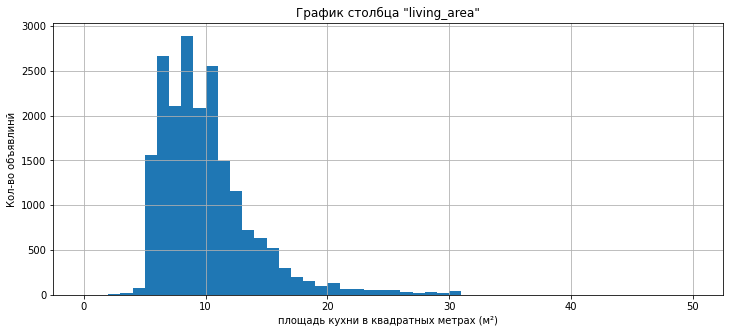

In [99]:
data['kitchen_area'].hist(bins=50, range=(0,50) , figsize=(12,5))
plt.title('График столбца "living_area"')
plt.xlabel('площадь кухни в квадратных метрах (м²)')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Самая распростроненная площядь кухни, это около 7-ми кв.м. Так же видно по графику, что кухни воснавном размеров 7, 9 и 12 кв.м.

#### Цена обекта

Стоимость квартир начинается выше 1 млн. По этому изменим кратность 1 = 1млн.

In [100]:
data['last_price'] = data['last_price']/1000000 

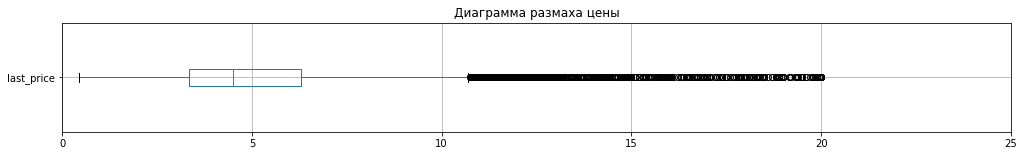

In [101]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха цены')
ax.set_xlim(0, 25);

In [102]:
data['last_price'].describe()

count    21940.000000
mean         5.208679
std          2.926225
min          0.430000
25%          3.350000
50%          4.500000
75%          6.299250
max         20.000000
Name: last_price, dtype: float64

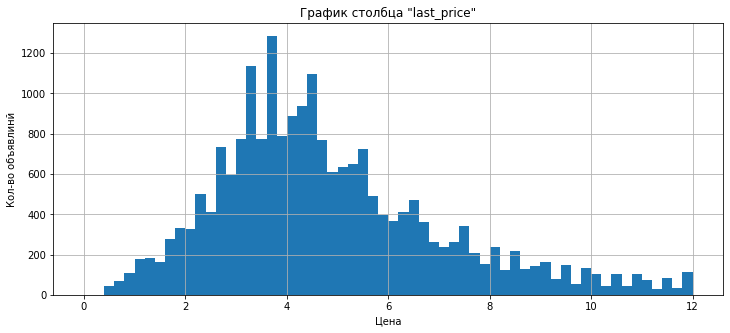

In [103]:
data['last_price'].hist(bins=60, range=(0,12), figsize=(12,5) )
plt.title('График столбца "last_price"')
plt.xlabel('Цена')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Из диограммы размаха выидим, что квартиры дороже 12 млн. встерячются редко, по этому уберем выпады из данных на составление гистограммы. В среднем квартиры стоят 4 млн.

#### Количество комнат

In [104]:
data['rooms'].describe()

count    21940.000000
mean         1.958204
std          0.915866
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

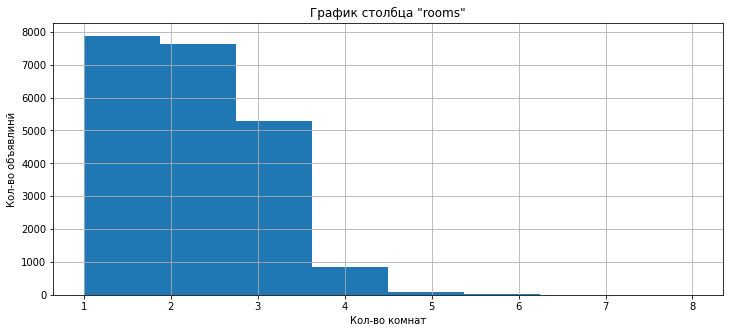

In [105]:
data['rooms'].hist(bins=8, range=(1,8), figsize=(12,5))
plt.title('График столбца "rooms"')
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** На рынке недвижимости больше всего предложений о продажи квартир 1,5 и 2-х комнатный квартир

#### Высота потолков

In [106]:
data['ceiling_height'].describe()

count    21940.000000
mean         2.707553
std          0.199607
min          2.000000
25%          2.600000
50%          2.720000
75%          2.720000
max          8.000000
Name: ceiling_height, dtype: float64

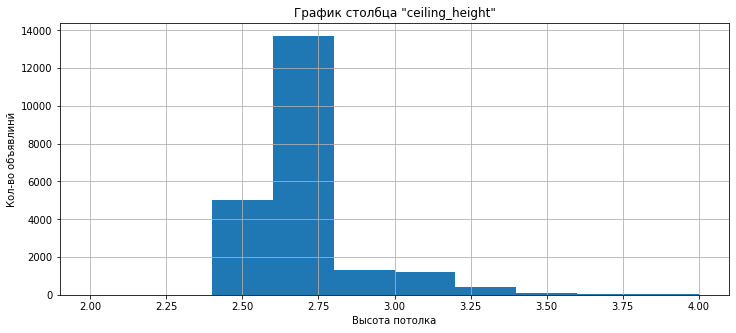

In [107]:
data['ceiling_height'].hist(bins=10, range=(2,4), figsize=(12,5) )
plt.title('График столбца "ceiling_height"')
plt.xlabel('Высота потолка')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Столбец с высотой птолкой, обследовали ранее и все выпоады привели к среднему значению. 

#### Этаж квариры

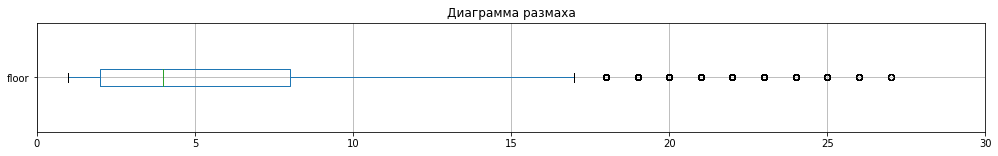

In [108]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['floor']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха')
ax.set_xlim(0, 30);

In [109]:
data['floor'].describe()

count    21940.000000
mean         5.905834
std          4.887995
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

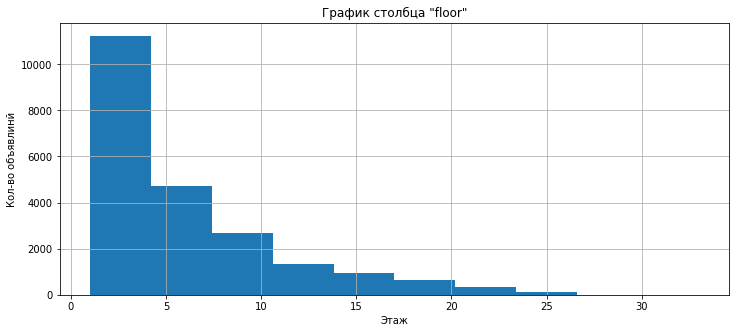

In [110]:
data['floor'].hist(bins=10, range=(1,33), figsize=(12,5))
plt.title('График столбца "floor"')
plt.xlabel('Этаж')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Большенство квартир в продаже находятся в деопазоне 2-5 этажа.

#### Тип этажей квариры

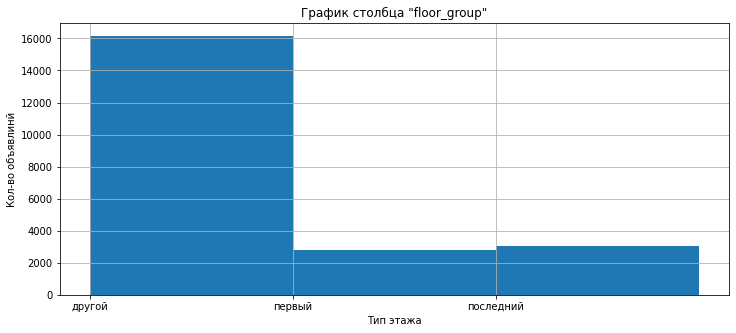

In [111]:
data['floor_group'].hist(bins=3, range=(0,3), figsize=(12,5) )
plt.title('График столбца "floor_group"')
plt.xlabel('Тип этажа')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Судя по графику, более актуальны квартиры на любом другом этаже кроме первого и последнего

#### Общее количество этажей в доме

In [112]:
data['floors_total'].describe()

count    21940.000000
mean        10.722425
std          6.597378
min          0.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

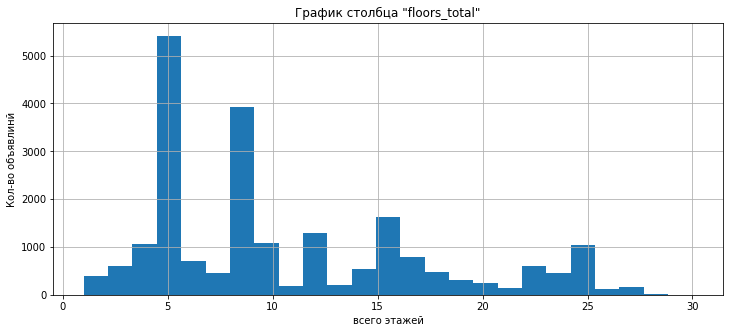

In [113]:
data['floors_total'].hist(bins=25, range=(1,30),figsize=(12,5) )
plt.title('График столбца "floors_total"')
plt.xlabel('всего этажей')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Из анализа мы видим городе преоблодает пятиэтажные постройки.

#### Расстояние до центра города в метрах

In [114]:
data['city_centers_nearest'].describe()

count    16570.000000
mean     14680.843754
std       8494.962310
min        208.000000
25%      10251.000000
50%      13382.000000
75%      16518.000000
max      65952.000000
Name: city_centers_nearest, dtype: float64

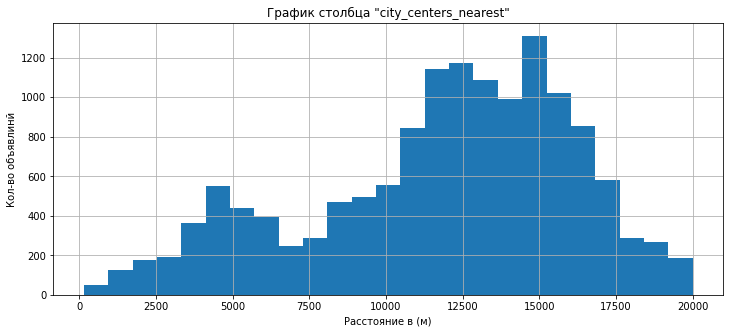

In [115]:
data['city_centers_nearest'].hist(bins=25, range=(150,20000), figsize=(12,5))
plt.title('График столбца "city_centers_nearest"')
plt.xlabel('Расстояние в (м)')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Большенство объявлений о прдаже квартира находящихся ближе к окрание, нежели к центру.

#### Расстояние до ближайшего аэропорта

In [116]:
data['airports_nearest'].describe()

count    16552.000000
mean     28936.992267
std      12879.949521
min       6450.000000
25%      18250.250000
50%      27122.000000
75%      37554.750000
max      84853.000000
Name: airports_nearest, dtype: float64

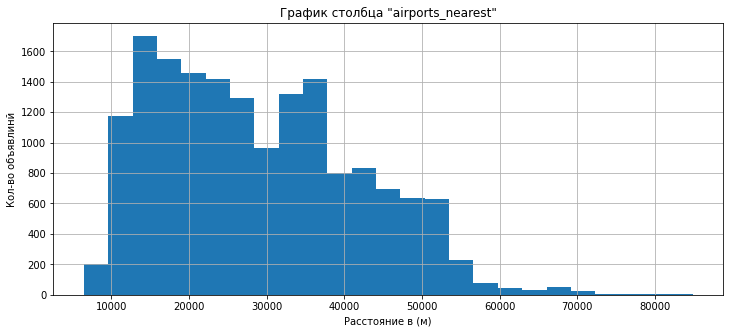

In [117]:
data['airports_nearest'].hist(bins=25, range=(6450,84869), figsize=(12,5))
plt.title('График столбца "airports_nearest"')
plt.xlabel('Расстояние в (м)')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Основное колличество квартир находятся не растоянии до 30 км к Аэропорту.

#### Расстояние до ближайшего парка

In [118]:
data['parks_nearest'].describe()

count    7092.000000
mean      493.221235
std       337.645894
min         1.000000
25%       290.000000
50%       458.000000
75%       616.000000
max      3190.000000
Name: parks_nearest, dtype: float64

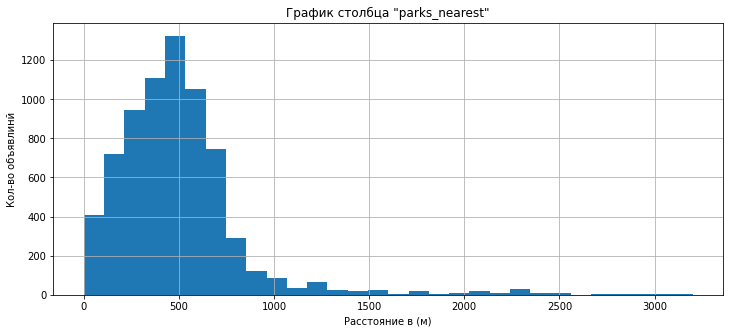

In [119]:
data['parks_nearest'].hist(bins=30, range=(1,3200), figsize=(12,5))
plt.title('График столбца "parks_nearest"')
plt.xlabel('Расстояние в (м)')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Больше половыны обявлений без указания растояния, вероятно парки находятся очень долеко. По остальным объявление в среднем растояние до парка равна 500 метрам.

#### День и месяц публикации объявления

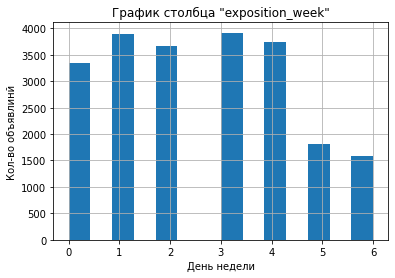

In [120]:
data['exposition_week'].hist(bins=14, range=(0,6), )
plt.title('График столбца "exposition_week"')
plt.xlabel('День недели')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Обявления выкладывают больше всего по четвергам и вторникам, а реже на выходных

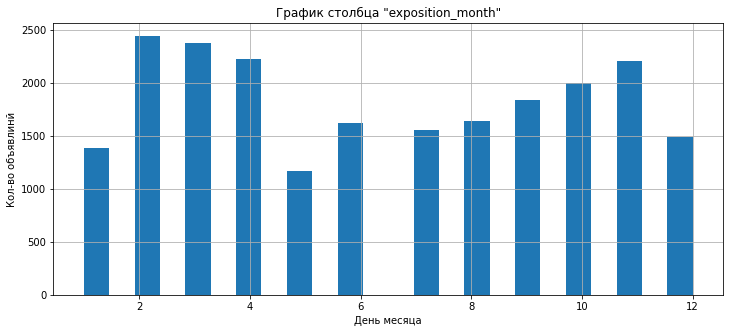

In [121]:
data['exposition_month'].hist(bins=24, range=(1,12), figsize=(12,5))
plt.title('График столбца "exposition_month"')
plt.xlabel('День месяца')
plt.ylabel('Кол-во объявлинй')
plt.show()

**Вывод:** Больше всего квартир выставляют на продажу в первок квартале года. А в мае кольчиество новых объявлений ниже всего в году.

#### Вывод

По результату проведённого анализа, однозначно можно сказать, что подавляющее большинство объявлений о продаже квартир составляют 1-2 комнатные квартиры в ценовом диапазоне 4 млн.руб и высотой потолков в 2,72 метра, на 2-5 этаже. А больше всего домов пятиэтажных

### Изучим, как быстро продавались квартиры

В этом разделе мы ответим на вопросы: сколько времени обычно занимает продажа? Какие продажи можно считать быстрыми, а какие — необычно долгими?

In [122]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition,total_area_price,exposition_week,exposition_month,exposition_year,floor_group,centers_nearest_km
0,20,13.000,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,NaN,3,3,2019,другой,16.0
1,7,3.350,40.40,2018-12-04,1,2.72,11,18.60,1,False,False,False,11.00,2,посёлок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5.196,56.00,2015-08-20,2,2.72,5,34.30,4,False,False,False,8.30,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0
5,10,2.890,30.40,2018-09-10,1,2.72,12,14.40,5,False,False,False,9.10,0,городской посёлок янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065.79,0,9,2018,другой,NaN
6,6,3.700,37.30,2017-11-02,1,2.72,26,10.60,6,False,False,False,14.40,1,посёлок парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,99195.71,3,11,2017,другой,19.0
7,5,7.915,71.60,2019-04-18,2,2.72,24,NaN,22,False,False,False,18.90,2,санкт-петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,110544.69,3,4,2019,другой,12.0
8,20,2.900,33.16,2018-05-23,1,2.72,27,15.43,26,False,False,False,8.81,0,посёлок мурино,NaN,NaN,0,NaN,0,NaN,189.0,87454.76,2,5,2018,другой,NaN
9,18,5.400,61.00,2017-02-26,3,2.50,9,43.60,7,False,False,False,6.50,2,санкт-петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,88524.59,6,2,2017,другой,15.0
10,5,5.050,39.60,2017-11-16,1,2.67,12,20.30,3,False,False,False,8.50,0,санкт-петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,127525.25,3,11,2017,другой,14.0
11,9,3.300,44.00,2018-08-27,2,2.72,5,31.00,4,False,False,False,6.00,1,ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0,75000.00,0,8,2018,другой,52.0


Из таблицы видно, что есть пропущенные значение. Предположим, что эти обявления еще актуальны, а квартиры не проданы. в том иследовании нам они не интересны

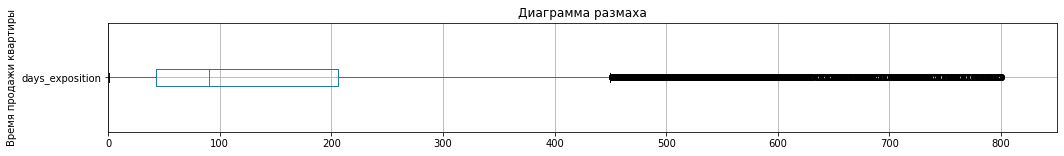

In [123]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['days_exposition']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха')
ax.set_xlim(0, 850);
plt.ylabel('Время продажи квартиры')
plt.show()

In [124]:
data['days_exposition'].describe()

count    19082.000000
mean       152.748297
std        162.756115
min          1.000000
25%         43.000000
50%         90.000000
75%        206.000000
max        800.000000
Name: days_exposition, dtype: float64

Изучив данные диаграмы размаха, пришли к выводу, что значение выше 300 дней лучше осчет. Как правило очень долго продаются квартиры с нестандартной планировкой или слишком дорогие квартиры.

In [125]:
data.query('days_exposition < 300')['days_exposition'].agg(['mean','median'])

mean      92.020633
median    67.000000
Name: days_exposition, dtype: float64

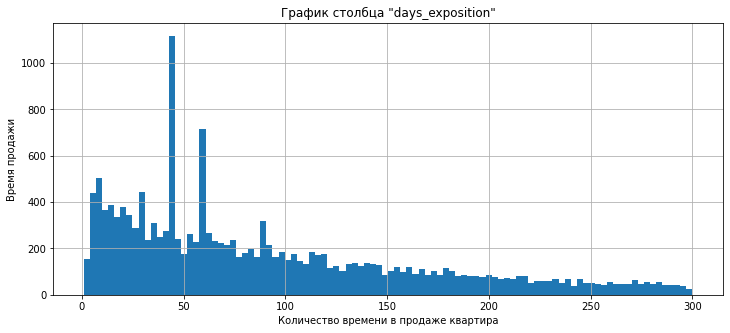

In [126]:
data.query('days_exposition < 300')['days_exposition'].hist(bins=100, range=(1,300), figsize=(12,5))
plt.title('График столбца "days_exposition"')
plt.xlabel('Количество времени в продаже квартира')
plt.ylabel('Время продажи')
plt.show()

**Вывод:** На продажу среднестатистической квартиры, в среднем уходит 2-3 месяца. Дольше всего продаются квартиры с нестандартной планировкой и высокой ценой. Быстрыми продажами можно назвать, квартиры, продававшиеся меньше месяца

### Изучим вопрос: "Какие факторы больше всего влияют на общую (полную) стоимость объекта?"

#### Изучим влияние общей, жилой и кухонной площадей на общую стоимость

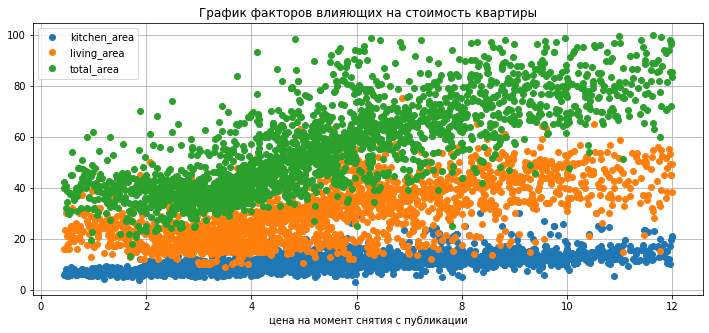

In [127]:
data.query('last_price < 12 and total_area < 100' ).pivot_table(index='last_price', values=['total_area', 'living_area', 'kitchen_area']).plot(style='o', grid=True, figsize=(12, 5))
plt.title('График факторов влияющих на стоимость квартиры')
plt.xlabel('цена на момент снятия с публикации')
plt.show()

**Вывод:** Общая площадь квартиры прямо влияем на её общую стоимость. Так же не отстают жилая и кухонная площади.

#### Рассмотрим как влияет на общую стоимость количество комнат

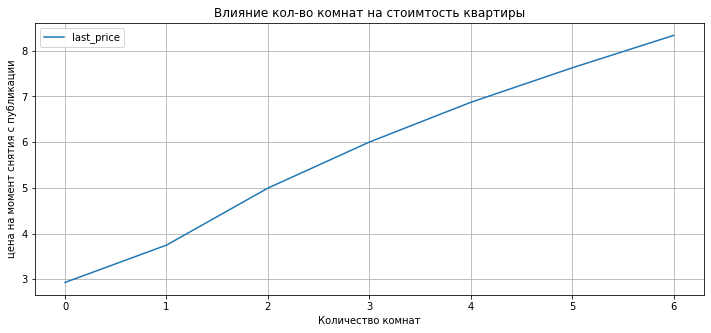

In [128]:
(data.query('last_price < 12 and rooms < 7' ).pivot_table(index='rooms', values=['last_price'])
 .plot(style='', grid=True, figsize=(12, 5)))
plt.title('Влияние кол-во комнат на стоимтость квартиры')
plt.xlabel('Количество комнат')
plt.ylabel('цена на момент снятия с публикации')
plt.show()

**Вывод:** Количество комнат прямо влияем на её общую стоимость.

#### Рассмотрим как влияет на общую стоимость этажа, на котором расположена квартира (первый, последний, другой)

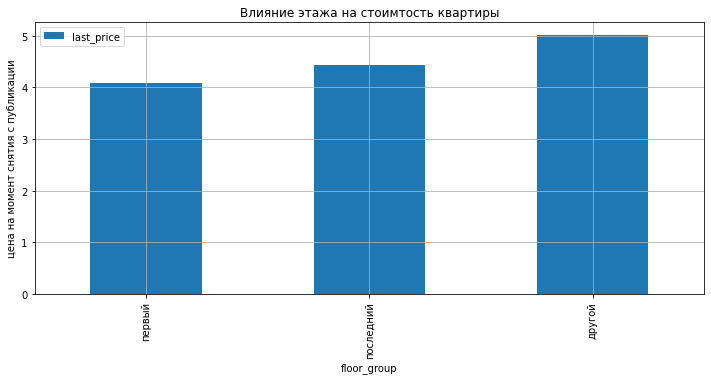

In [129]:
(data.query('last_price < 12' ).pivot_table(index='floor_group', values=['last_price']).sort_values(by='last_price')
 .plot(grid=True, figsize=(12, 5), kind='bar'))
plt.title('Влияние этажа на стоимтость квартиры')
plt.ylabel('цена на момент снятия с публикации')
plt.show()

**Вывод:** Самые дешёвые квартиры расположены на первом этаже. Дороже всего цена квартир, которые находится не на первом и не на последнем этажах.

#### Рассмотрим как влияет на общую стоимость даты размещения (день недели, месяц, год).

По дням недели

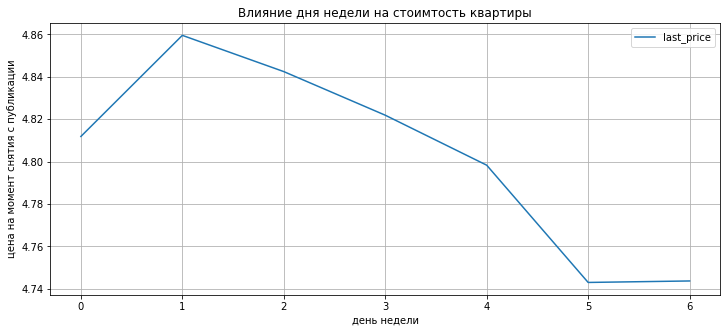

In [130]:
data.query('last_price < 12' ).pivot_table(index='exposition_week', values=['last_price']).plot(style='-', grid=True, figsize=(12, 5))
plt.title('Влияние дня недели на стоимтость квартиры')
plt.ylabel('цена на момент снятия с публикации')
plt.xlabel('день недели')
plt.show()

По месяцам

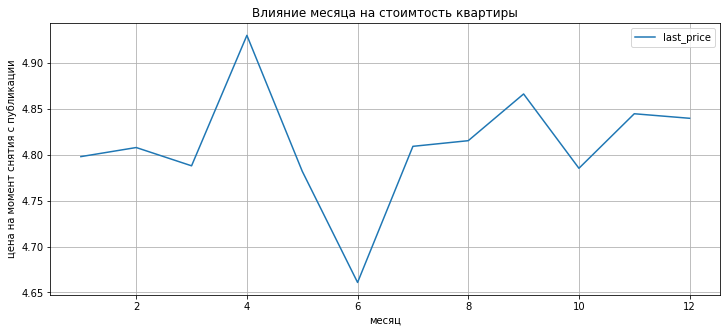

In [131]:
data.query('last_price < 12' ).pivot_table(index='exposition_month', values=['last_price']).plot(style='-', grid=True, figsize=(12, 5))
plt.title('Влияние месяца на стоимтость квартиры')
plt.ylabel('цена на момент снятия с публикации')
plt.xlabel('месяц')
plt.show()

По годам

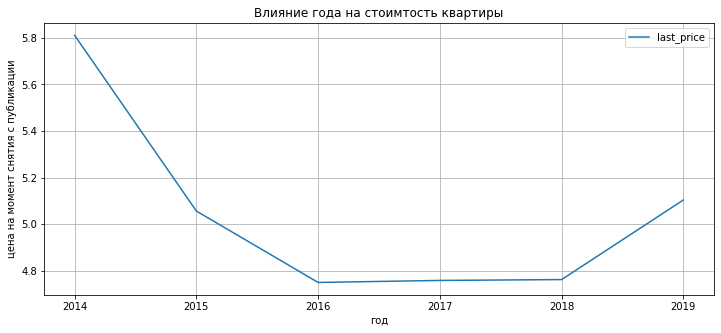

In [132]:
data.query('last_price < 12' ).pivot_table(index='exposition_year', values=['last_price']).plot(style='-', grid=True, figsize=(12, 5))
plt.title('Влияние года на стоимтость квартиры')
plt.ylabel('цена на момент снятия с публикации')
plt.xlabel('год')
plt.show()

**Вывод:** Удивительно, но объявление размещённые во вторник самые высокие и к выходным  плавно снижаются. На месячной диаграмме отчетливо видно два месяца где цена на конец публикации самая высокая, и сильно выделятся месяц где цена самая низкая. По годовалой диаграмме наблюдается снижение цены в период с 2014 по 2016, потом период застоя и только с 2018 года цена начинает расти.

### Выделим 10 населённых пунктов с наиболее высокой ценой за квадратный метр

In [133]:
top_locality = data.pivot_table(index='locality_name', values=['last_price'], aggfunc='count').sort_values(by='last_price', ascending=False).head(10)
top_locality.columns=['total_ads']

In [134]:
top_locality

,total_ads
locality_name,
санкт-петербург,14199
посёлок мурино,542
посёлок шушары,430
всеволожск,387
пушкин,338
колпино,332
посёлок парголово,321
гатчина,296
деревня кудрово,289


Вывили общее количество объявлений в каждом населенном пункте.

In [135]:
top_locality['total_area_price'] = (data.pivot_table(index='locality_name', values=['total_area_price'], aggfunc='mean')).round(2)

In [136]:
top_locality

,total_ads,total_area_price
locality_name,,
санкт-петербург,14199,105584.47
посёлок мурино,542,85822.07
посёлок шушары,430,78667.84
всеволожск,387,67176.30
пушкин,338,100072.02
колпино,332,75162.72
посёлок парголово,321,90235.72
гатчина,296,68640.78
деревня кудрово,289,92526.62


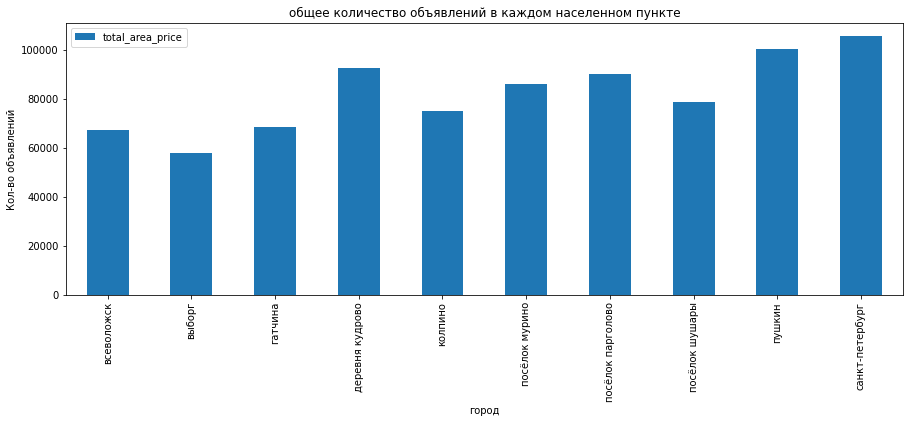

In [137]:
top_locality.pivot_table(index='locality_name', values='total_area_price').plot(kind='bar', figsize=(15,5))
plt.title('общее количество объявлений в каждом населенном пункте')
plt.ylabel('Кол-во объявлений')
plt.xlabel('город')
plt.show()

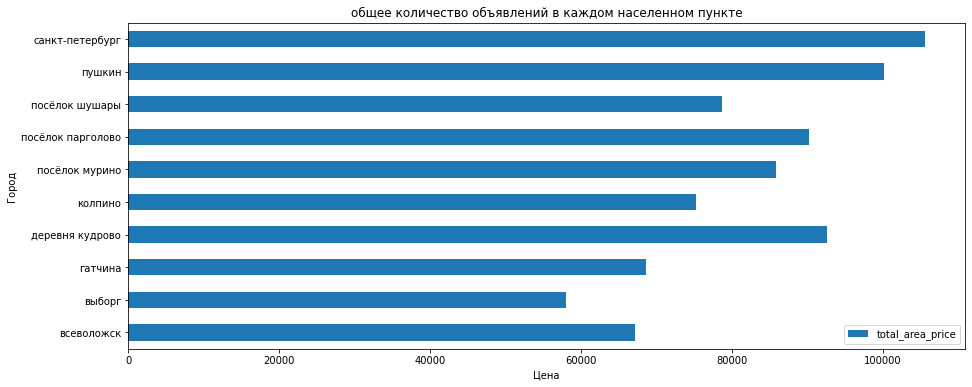

In [138]:
top_locality.pivot_table(index='locality_name', values='total_area_price').plot(kind='barh', figsize=(15,6));
plt.title('общее количество объявлений в каждом населенном пункте')
plt.ylabel('Город')
plt.xlabel('Цена')
plt.show()

**Вывод:** На среднюю стоимость за кв.м. жилья не сильно влияет низкое количество объявлений в данном населённом пункте. Так к примеру населенный пункт Пушкин, по цене не сильно уступает городу Санкт-Петербургу.

Выведем населённые пункты с самой высокой стоимостью квадратного метра

In [139]:
top_locality.query('total_area_price == total_area_price.max()')

,total_ads,total_area_price
locality_name,,
санкт-петербург,14199,105584.47


Выведем населённые пункты с самой низкой стоимостью квадратного метра

In [140]:
top_locality.query('total_area_price == total_area_price.min()')

,total_ads,total_area_price
locality_name,,
выборг,226,57992.87


**Вывод:** Самым дорогой стоимостью квадратного метра является г. Санкт-Петербург, а с самой дешёвой Выборг.

### Вычислим влияние на стоимость жилья каждого километра ближе к центру

**Выделим недвижимость находящиеся в г. Санкт-Петербург**

In [141]:
price_house_city = data.query('locality_name == "санкт-петербург"')

**Проверим сколько строк с пустым значение в столбце centers_nearest_km**


In [142]:
price_house_city['centers_nearest_km'].isna().sum()

43

**Пропущеных значений менее 1%, просто удалим.**

In [143]:
price_house_city = price_house_city.dropna(subset=['centers_nearest_km'])

In [144]:
price_house_city['centers_nearest_km'].isna().sum()

0

**Построим диаграмму размаха**

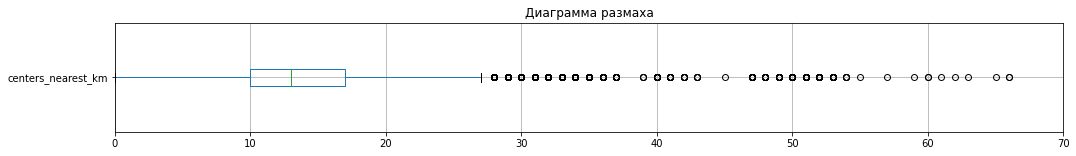

In [145]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['centers_nearest_km']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха')
ax.set_xlim(0, 70);
plt.show()

По гистограмме видно, что некоторые значения находятся на большом расстоянии от центра. Проверив данных в Яндекс.Картах, мы видим, что крайняя точка от центра города находится на уровне 25 км., поэтому мы отсечем мешающие статистике и анализу данные

In [146]:
price_house_city = price_house_city.query('centers_nearest_km < 25')

**Посчитаем среднюю стоимость каждого километра**

In [147]:
mean_price_km = ((price_house_city['last_price'].sum()/price_house_city['centers_nearest_km'].sum())*1000000).round(2)
print(f'Средняя цена для каждого километра составляет {mean_price_km} руб.')

Средняя цена для каждого километра составляет 518348.31 руб.


**Построим график зависимости цены от расстояния до центра**

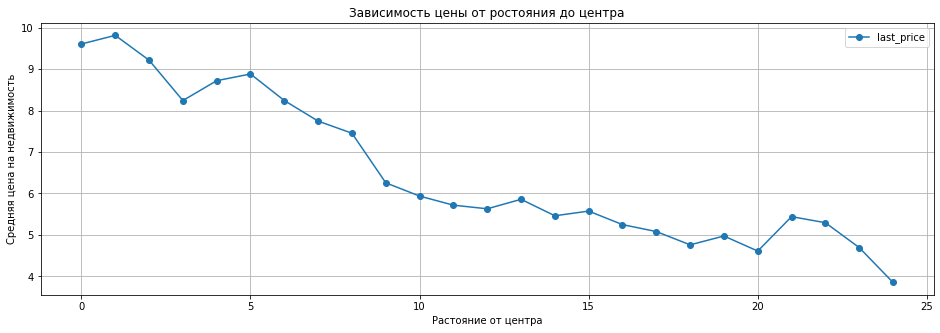

In [148]:
(price_house_city.pivot_table(index='centers_nearest_km', values='last_price', aggfunc='mean').
 plot(figsize=(16, 5), grid=True,  style='o-') )
plt.title('Зависимость цены от ростояния до центра')
plt.ylabel('Средняя цена на недвижимость')
plt.xlabel('Растояние от центра')
plt.show()

In [149]:
price_house_city['centers_nearest_km'].describe()

count    14063.000000
mean        11.935647
std          4.527628
min          0.000000
25%          9.000000
50%         13.000000
75%         15.000000
max         24.000000
Name: centers_nearest_km, dtype: float64

**Вывод:** Видим, что падение цены сильно изменилось при достижении 8 км. То есть самая дорогая недвижимость находится в приделах 8 км от центра города, и наверняка является центральным районом. Блеже к окраенам, цены примерно одинаковые и не сильно зависят от растояния до ценьра.

## Общий вывод

Подведём итог о проделанной работе. При подготовки данных к анализу было обнаружено большое количество пропусков в столбцах, которые могут повлиять на среднюю цену, предложения квартир, да и на всю итоговый анализ в целом.  Какие-то данные мы заполнили средними значениями, что-то оставили без изменений, а некоторые удалили во все. Ошибок, связанных с человеческим фактором, не так уж и много, что сильно облегчило труд при обработки данных. А вот целостность данных при выгрузке или заполнения ячеек сильно хромает, об этом обязательно нужно сообщить коллегам ответственным за выгрузку и сбор данных.

После предобработки данных, провели исследование, какие факторы в больше степени влияю на стоимость жилья, узнали среднее время продажи недвижимости, высинили и проанализировали среднюю стоимость жилья. Так же вычалили как сильно влияет цена от удаленности от центра. Узнали стоимость каждого километра удаления от центра.  Для наглядности использовали графики, гистограммы, диаграммы из них легче сделать выводы.
Лидером по размещению объявлений является Санкт-Петербург, не смотря на это есть в ближайших населенных пунктах стоимость приблизительно такая же как в городе. Тенденция рынка такова, что начиная с 2018 года активно растёт спрос на жильё за пределами центра Петербурга, при этом люди в основном стараются найти предложения квартир на любом этаже за исключением первого и последнего.

В большинстве случаев при покупке жилья, люди выбирают 1-2 комнатные квартиры, со средней стоимостью жилья 4 млн. руб. и высотой потолков 2,7, по периметру города Санкт-Петребург.